# REIT

- MSCI US REIT Custom Capped Index (BBRE)
- IFGL

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns

In [32]:
ticker_list = ['BBRE', 'IFGL']
tiskers = yf.Tickers(' '.join(ticker_list))
historical_data = tiskers.history(period='max')


[*********************100%***********************]  2 of 2 completed


## Returns

In [38]:
df = pl.DataFrame({
    "Date": historical_data.index,
    "us_reit": historical_data['Close']['BBRE'],
    "ex_us_reit": historical_data['Close']['IFGL'],
    "us_reit_include_div": historical_data['Close']['BBRE'] + historical_data['Dividends']['BBRE'],
    "ex_us_reit_include_div": historical_data['Close']['IFGL'] + historical_data['Dividends']['IFGL'],
})

In [39]:
df = df.drop_nulls(subset=["us_reit"]).with_columns([
    pl.col("us_reit_include_div").log().alias("us_reit_log"),
    pl.col("ex_us_reit_include_div").log().alias("ex_us_reit_log")
]).with_columns([
    pl.col("us_reit_log").diff().fill_null(value=0).alias("us_reit_log_diff"),
    pl.col("ex_us_reit_log").diff().fill_null(value=0).alias("ex_us_reit_log_diff"),
]).with_columns([
    pl.col("us_reit_log_diff").cum_sum().alias("us_reit_log_cumsum"),
    pl.col("ex_us_reit_log_diff").cum_sum().alias("ex_us_reit_log_cumsum"),
]).with_columns([
    ((pl.col("us_reit_log_cumsum").exp() - 1)*100).alias("us_reit_return"),
    ((pl.col("ex_us_reit_log_cumsum").exp() - 1)*100).alias("ex_us_reit_return"),
])

Text(0, 0.5, '累積リターン (%)')

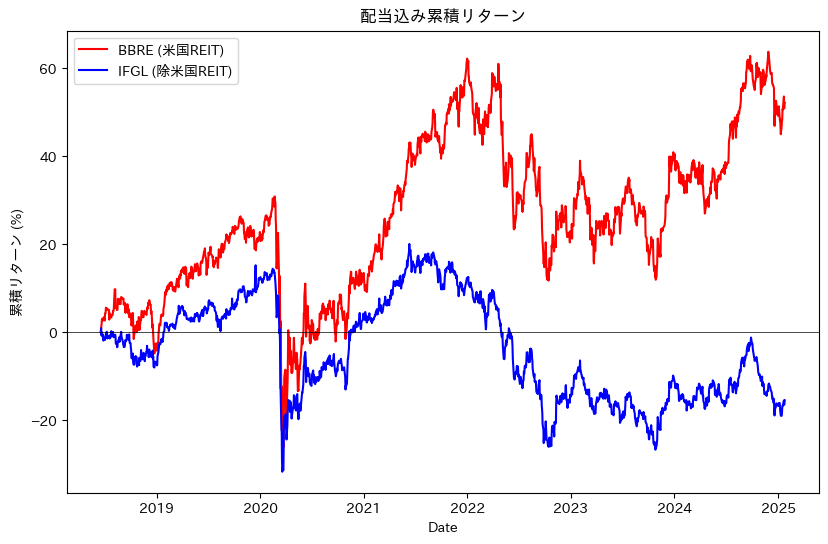

In [40]:
fig, ax = plt.subplots(figsize=(1.618*6, 6))
sns.lineplot(data=df.to_pandas(), x='Date', y='us_reit_return', ax=ax, label='BBRE (米国REIT)', color='red')
sns.lineplot(data=df.to_pandas(), x='Date', y='ex_us_reit_return', ax=ax, label='IFGL (除米国REIT)', color='blue')
ax.axhline(0, color='black', linewidth=0.5)
ax.set_title("配当込み累積リターン")
ax.set_ylabel('累積リターン (%)')

## Volatility

In [56]:
volatility_df = df.select([
    pl.col("us_reit_log_diff"),
    pl.col("ex_us_reit_log_diff"),
])

In [60]:
volatility_df

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.0,0.0
0.005165,0.008622
0.009205,-0.014152
0.00431,-0.002726
0.010501,0.007478
…,…
-0.000779,0.0
0.019836,0.014411
-0.017969,-0.011822


In [57]:
volatility_df.std() * np.sqrt(252)

us_reit_log_diff,ex_us_reit_log_diff
f64,f64
0.240079,0.185878


$$
\text{variance} = w^{\top} \cdot \Sigma \cdot w
$$

- $w$: weight
- $\Sigma$: covariance matrix

In [90]:
from scipy.optimize import minimize

num_assets = 2

tmp = np.array([volatility_df['us_reit_log_diff'], volatility_df['ex_us_reit_log_diff']])
cov_matrix = np.cov(tmp)

def portfolio_variance(weights):
    var = weights.T @ cov_matrix @ weights
    return np.sqrt(var) * np.sqrt(252)

def constraint_sum_of_weights(weights):
    return np.sum(weights) - 1

constraints = [
    {"type": "eq", "fun": constraint_sum_of_weights}
]

initial_guess = np.ones(num_assets) / num_assets

bounds = [(0, 1) for _ in range(num_assets)]

result = minimize(portfolio_variance, initial_guess, constraints=constraints, bounds=bounds)

print(f"Optimal portfolio variance: {result.fun:.3%}")
print("Optimal portfolio weights")
print(f'BBRE: {result.x[0]:.2%}, IFGL: {result.x[1]:.2%}')

Optimal portfolio variance: 18.502%
Optimal portfolio weights
BBRE: 10.50%, IFGL: 89.50%
